<a href="https://colab.research.google.com/github/jrgreen7/SYSC4906/blob/master/W2025/Assignments/Assignment2/Ass2_SYSC4415_W25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SYSC4415 Assignment 2 – Fire Hydrant Detection 🚒

"""
Special thanks to Nader Ibrahim for assembling the dataset. For more details, please refer to the paper:

Ibrahim N, Dick K, Green JR. Computer Vision Fire Hydrant Obstruction Detection System. In2024 IEEE Canadian Conference on Electrical and Computer Engineering (CCECE) 2024 Aug 6 (pp. 799-805). IEEE.

"""

## Dataset
Provided on Brightspace.

#### Dataset details:
- Training Images: 2,272  
- Validation Images: 563  
- Labels: 0 = No Fire Hydrant, 1 = Fire Hydrant  
- Imbalanced dataset (most images do not contain a hydrant).

#### Dataset Information
The dataset contains two main folders:
- `train/`: Contains the training images and a CSV file with labels.
- `valid/`: Contains the validation images and a CSV file with labels.

Each folder includes:
- Images of fire hydrants and non-fire hydrants.
- A CSV file (`_classes.csv`) mapping each image filename to its label:
  - `0` for no fire hydrant.
  - `1` for fire hydrant.

Ensure the zip file of the dataset (FH_detection_data.zip) to your Google Drive and placed under "My Drive" without any subfolders to keep the paths consistent.



## Steps

### 1) Initial Setup
Import necessary libraries


In [ ]:
# Import all the necessary libraries here

import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from torchvision import transforms

Mount Google Drive and unzip the dataset.

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Unzip the dataset
!unzip /content/drive/MyDrive/FH_detection_data.zip -d /content/


# Dataset path
train_data_path = "/content/train"
valid_data_path = "/content/valid"
train_label = pd.read_csv('/content/train/_classes.csv')
valid_label = pd.read_csv('/content/valid/_classes.csv')

Mounted at /content/drive
Archive:  /content/drive/MyDrive/FH_detection_data.zip
   creating: /content/train/
 extracting: /content/train/10063782964_891eedde4e_z_jpg.rf.4caba9d0e35546b469aa896df780d833.jpg  
 extracting: /content/train/100_PNG.rf.d52fbff94c483761d0644a1e8abe4c95.jpg  
 extracting: /content/train/101_PNG.rf.f1335e18f815c8c8044a94c09db7f025.jpg  
 extracting: /content/train/102378468_d8132a415b_z_jpg.rf.6bc008d0d532d3365f580b7aaa7623e3.jpg  
 extracting: /content/train/102_PNG.rf.160c945e0881c92a078a14069d9a6b9a.jpg  
 extracting: /content/train/102_jpg.rf.17df75e9dda0f851c9f5e1d554f07488.jpg  
 extracting: /content/train/103357395_388d701e12_z_jpg.rf.a54c985e93402af49ba422f005e702d8.jpg  
 extracting: /content/train/103_jpg.rf.a649213f3998906bf2298607f82ee839.jpg  
 extracting: /content/train/104351403_25e959f878_z_jpg.rf.43156bd0a74313df69967d88e5e6a268.jpg  
 extracting: /content/train/104_PNG.rf.c14671a6a52ae05f9ae2bf1df7e4316e.jpg  
 extracting: /content/train/104_

----

### 2) Data Exploration
1. Load dataset into a pandas DataFrame.
2. Display display three sample images from each class
3. Create separately class distribution plots of the train and validation data
[Requires 6 sample images (three from each class) and two plots of class distribution (train and validation)]

❓ Why is it important to check for class imbalance before training? How might this affect our model?  
✅ Your answer here
..

Its important to check for class imbalance before trainning because if there is a major imbalance of distribution the model might get the best accurracy by just guess the majority class everytime. This would affect our model by probably giving it a high bias and less likely to classify the class with less of a presence in the data.

Samples with Fire Hydrant (Class 1):


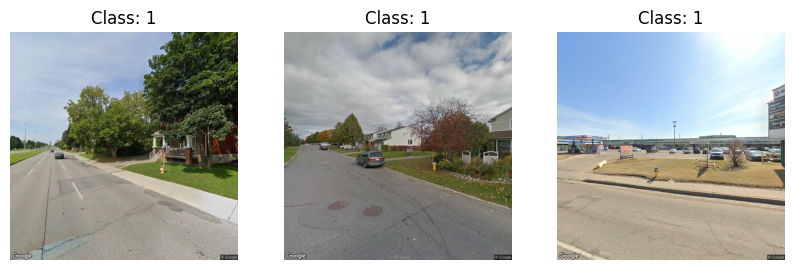

Samples without Fire Hydrant (Class 0):


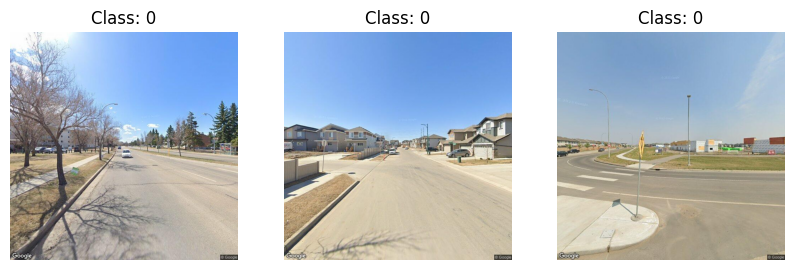

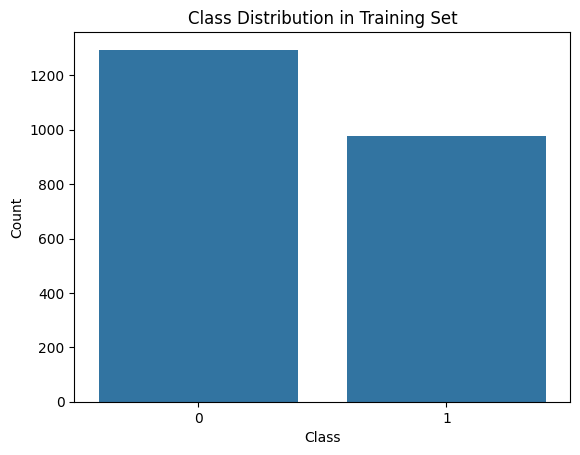

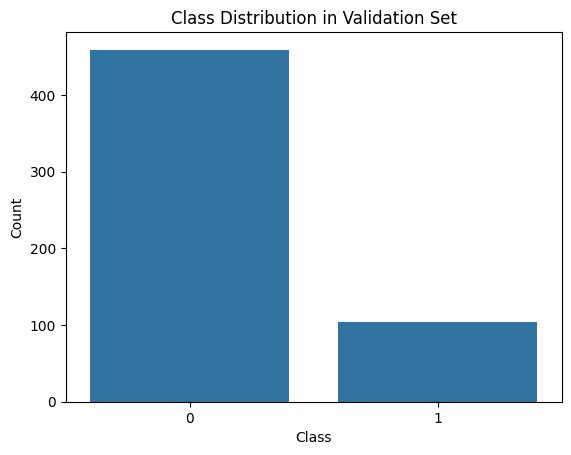

In [ ]:
train_label['image_path'] = train_label['filename'].apply(lambda x: os.path.join(train_data_path, x))
valid_label['image_path'] = valid_label['filename'].apply(lambda x: os.path.join(valid_data_path, x))

# Display the first few rows of the DataFrame
train_label.head()

# Function to display images
def display_images(df, class_label, num_samples):
    class_samples = df[df['Fire Hydrants'] == class_label].sample(num_samples)
    plt.figure(figsize=(10, 5))
    for i, (index, row) in enumerate(class_samples.iterrows()):
        image = Image.open(row['image_path'])
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(image)
        plt.title(f"Class: {class_label}")
        plt.axis('off')
    plt.show()

# Display 3 samples from each class
print("Samples with Fire Hydrant (Class 1):")
display_images(train_label, class_label=1, num_samples=3)

print("Samples without Fire Hydrant (Class 0):")
display_images(train_label, class_label=0, num_samples=3)

# Plotting class distributions
sns.countplot(x='Fire Hydrants', data=train_label)
plt.title("Class Distribution in Training Set")
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

sns.countplot(x='Fire Hydrants', data=valid_label)
plt.title("Class Distribution in Validation Set")
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

---

### 3) Preprocessing
- Resize images to 128x128.
- Apply any other necessary transformations that you feel can help.

❓ Would one-hot encoding be necessary for binary classification? Why or why not?  
✅ Your answer here..

No one-hot encoding is not necessary for binary classification, because there are only two values, either it is or it is not (a photo containing a firehydrant).

In [ ]:
# Function to resize an image to 128x128
def resize_image(image_path, size=(128, 128)):
    image = Image.open(image_path)
    resized_image = image.resize(size)
    return resized_image

# Resize all images
train_label['resized_image'] = train_label['image_path'].apply(lambda x: np.array(resize_image(x)))
valid_label['resized_image'] = valid_label['image_path'].apply(lambda x: np.array(resize_image(x)))


---

### 4) Creating the Baseline Model
Create a CNN with:
- Two convolutional layers to extract features from the images.
- Max pooling layers after each convolution to reduce spatial dimensions.
- Fully connected layers to perform classification.
- A sigmoid activation function at the output layer to output a probability between 0 and 1.

Required architecture:
- Input: RGB images resized to 128x128 pixels.
- Conv2d (3 input channels, 32 output channels, kernel size 3, padding 1)
- MaxPool2d (kernel size 2, stride 2, padding 0) – applied after the first Conv2d.
- Conv2d (32 input channels, 64 output channels, kernel size 3, padding 1)
- MaxPool2d (kernel size 2, stride 2, padding 0) – applied after the second Conv2d.
- Flatten
- Linear layer with 128 units
- Output Linear layer with 1 unit and sigmoid activation



This model will be trained to classify whether an image contains a fire hydrant or not.


❓ List three ways to improve the baseline model (e.g., adding dropout to... , using batch normalization to..., or increasing the number of layers to...,
be sure to come up with your own ideas!). Provide a brief explanation for each.

✅ Your answer here..

Three ways to improve the baseline model could be be by:
- Increasing the number of convolutional layers allow the CNN to be able to learn more features which could help in better recognition.

- Data Augmentation, by applying different transformations to the trainning dat we can increase the amount of data its being tested on.

- Dropout, by adding a dropout to the model it helps to prevent the model from overfitting by randomly dropping some "neurons" forcing the others to not be overreliant on each othe, enabling it to generalize better.

- Increasing the number of epochs to to allow it more iterations to train.

In [ ]:
class FireHydrantCNN(nn.Module):
    def __init__(self):
        super(FireHydrantCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 32 * 32, 128)  # Adjust input size based on image dimensions
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        # Convolutional layers with ReLU and max pooling
        x = self.pool1(F.relu(self.conv1(x)))  # Output: (batch_size, 32, 64, 64)
        x = self.pool2(F.relu(self.conv2(x)))  # Output: (batch_size, 64, 32, 32)

        # Flatten the output for fully connected layers
        x = self.flatten(x)  # Output: (batch_size, 64 * 32 * 32)

        # Fully connected layers
        x = F.relu(self.fc1(x))  # Output: (batch_size, 128)
        x = torch.sigmoid(self.fc2(x))  # Output: (batch_size, 1)

        return x

class FireHydrantDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = self.df.iloc[idx]['resized_image']
        label = self.df.iloc[idx]['Fire Hydrants']

        if self.transform:
            image = self.transform(image)

        # Ensure label is a tensor
        label = torch.tensor(label, dtype=torch.float32)

        return image, label

---

### 5) Training and Evaluation
Train your CNN using Binary Cross Entropy Loss and an Adam optimizer. Use a learning rate of 0.001. Iterate over your dataset for 10 epochs and track the loss. Train using the train data in /train.

Evaluate your model on the test data in /valid using Precision, Recall, and F1-Score to assess performance.


❓ Which evaluation metric you think is the most suitable in our case, and why?

✅ Your answer here

I think the most important metric is the precision metric, this is because the misidentification of there being a firehydrant when there isnt one could be detrimental to a fire department thus we would want to be sure that if the model predicts one to be in an image, that it is actually there. But of course we want good performance across as many metrics as possible.

Display the confusion matrix.

The confution matrix is shown using a seaborn heatmap display.

❓ Explain the confusion matrix to a non-technical audience and relate it to your chosen metric.  
✅ Your answer here

A confusion matrix's purpose is for use to assess the models performance. It compares four different values, true positives (when the model correctly makes a positive prediction), true negatives (when the model correctly makes a negative prediction), false positives (when the model incorrectly makes a positive prediction) and false negatives (when the model incorrectly makes a negative prediction). Precision is the ratio of true positives over the total number of positive predictions it made (true positives + false positives). Given this information you can assess how confident the model is when making a positive prediction, which I beleive is most important for determining if a firehydrant is in an image or not.

loading model from /content/drive/My Drive/content/fire_hydrant_cnn_V1.pth
Loaded model loaded successfully
2 Layered CNN after 10 epochs stats
Precision: 0.4609
Recall: 0.5673
F1-Score: 0.5086
Confusion Matrix:
[[390  69]
 [ 45  59]]


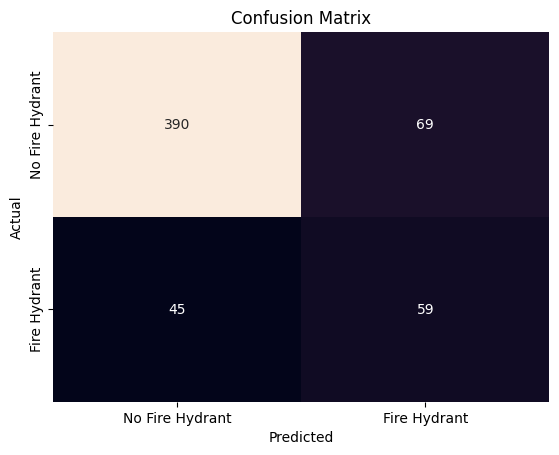

In [ ]:
def load_or_initialize_model(model_path,modelType):
    # model already exists so load it
    if os.path.exists(model_path):
        print(f"loading model from {model_path}")
        model = FireHydrantCNN()
        if modelType == 2:
          model = FireHydrantCNN_3Layers()
        if modelType == 3:
          model = FireHydrantCNN_DataAugmentation()
        if modelType == 4:
          model = FireHydrantCNN_dropout()
        model.load_state_dict(torch.load(model_path))
        model.eval()
        print("Loaded model loaded successfully")
      #model does not exist so initialize it
    else:
        print(f"No model found at {model_path}. initializing a new model")
        if modelType == 1:
          model = FireHydrantCNN()
        if modelType == 2:
          model = FireHydrantCNN_3Layers()
        if modelType == 3:
          model = FireHydrantCNN_DataAugmentation()
        if modelType == 4:
          model = FireHydrantCNN_dropout()
        print("New model initialized")

    return model




MODEL_SAVE_PATH = '/content/drive/My Drive/content/fire_hydrant_cnn_V1.pth'
model = load_or_initialize_model(MODEL_SAVE_PATH,1)


train_dataset = FireHydrantDataset(train_label, transform=transforms.ToTensor())
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

valid_dataset = FireHydrantDataset(valid_label, transform=transforms.ToTensor())
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)

# Training loop
if not os.path.exists(MODEL_SAVE_PATH):
  criterion = nn.BCELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

  num_epochs = 10
  for epoch in range(num_epochs):
      model.train()
      running_loss = 0.0

      for images, labels in train_loader:

          # Zero the gradients
          optimizer.zero_grad()

          # Forward pass
          outputs = model(images)
          loss = criterion(outputs.squeeze(), labels)

          # Backward pass and optimization
          loss.backward()
          optimizer.step()

          running_loss += loss.item()

      print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    # Save the trained model to Google Drive
  torch.save(model.state_dict(), MODEL_SAVE_PATH)
  print(f"Model saved to {MODEL_SAVE_PATH}")



model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in valid_loader:

        outputs = model(images)
        # Convert probabilities to binary predictions
        preds = (outputs.squeeze() > 0.5).float()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print("2 Layered CNN after 10 epochs stats")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Confusion matrix Display
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(cm)
sns.heatmap(cm, annot=True, fmt='d', cbar=False,
            xticklabels=['No Fire Hydrant', 'Fire Hydrant'],
            yticklabels=['No Fire Hydrant', 'Fire Hydrant'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

---


### 6) Model Improvements
Apply and evaluate three improvements ideas that you mentioned in the Baseline CNN question (Step 4).
Implement each idea separately, train a model with that improvement, and report the performance of each model using the metrics from Step 5. As above, train using the data in /train and test using the data in /valid.


❓ Which model would you deploy? Why?  
✅ Your answer here

I would deploy the third model in this section that employs the dropout technique, this is because from the results of the performance test it acheived the highest F1 score and a high precision score which I think is important.

In [ ]:
## ===============================================================
## Model with 3 Layers
## ===============================================================

class FireHydrantCNN_3Layers(nn.Module):
    def __init__(self):
        super(FireHydrantCNN_3Layers, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 32 * 32, 128)  # Adjust input size based on image dimensions
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        # Convolutional layers with ReLU and max pooling
        x = self.pool1(F.relu(self.conv1(x)))  # Output: (batch_size, 32, 64, 64)
        x = self.pool2(F.relu(self.conv2(x)))  # Output: (batch_size, 64, 32, 32)

        # Flatten the output for fully connected layers
        x = self.flatten(x)  # Output: (batch_size, 64 * 32 * 32)

        # Fully connected layers
        x = F.relu(self.fc1(x))  # Output: (batch_size, 128)
        x = torch.sigmoid(self.fc2(x))  # Output: (batch_size, 1)

        return x

model_3layer_save_path = '/content/drive/My Drive/content/fire_hydrant_cnn_3layer.pth'
model_3layer = load_or_initialize_model(model_3layer_save_path,2)

# Training loop
if not os.path.exists(model_3layer_save_path):
  criterion = nn.BCELoss()
  optimizer = torch.optim.Adam(model_3layer.parameters(), lr=0.001)

  num_epochs = 10
  for epoch in range(num_epochs):
      model_3layer.train()
      running_loss = 0.0

      for images, labels in train_loader:

          # Zero the gradients
          optimizer.zero_grad()

          # Forward pass
          outputs = model_3layer(images)
          loss = criterion(outputs.squeeze(), labels)

          # Backward pass and optimization
          loss.backward()
          optimizer.step()

          running_loss += loss.item()

      print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    # Save the trained model to Google Drive
  torch.save(model_3layer.state_dict(), model_3layer_save_path)
  print(f"model_3layer saved to {model_3layer_save_path}")



model_3layer.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in valid_loader:

        outputs = model_3layer(images)
        # Convert probabilities to binary predictions
        preds = (outputs.squeeze() > 0.5).float()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
print("3 Layered CNN after 10 epochs stats")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("======================================================")

## ===============================================================
## Model with its data being augmented
## ===============================================================

class FireHydrantCNN_DataAugmentation(nn.Module):
    def __init__(self):
        super(FireHydrantCNN_DataAugmentation, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 32 * 32, 128)  # Adjust input size based on image dimensions
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        # Convolutional layers with ReLU and max pooling
        x = self.pool1(F.relu(self.conv1(x)))  # Output: (batch_size, 32, 64, 64)
        x = self.pool2(F.relu(self.conv2(x)))  # Output: (batch_size, 64, 32, 32)

        # Flatten the output for fully connected layers
        x = self.flatten(x)  # Output: (batch_size, 64 * 32 * 32)

        # Fully connected layers
        x = F.relu(self.fc1(x))  # Output: (batch_size, 128)
        x = torch.sigmoid(self.fc2(x))  # Output: (batch_size, 1)

        return x

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

class FireHydrantDataset_Augmented(Dataset):
  def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

  def __len__(self):
        return len(self.data)

  def __getitem__(self, idx):
        # Access data as a tuple (image, label)
        image, label = self.data[idx]

        # Apply transforms if provided
        if self.transform:
            image = self.transform(image)
        else:
            image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)  # (H, W, C) -> (C, H, W)

        label = torch.tensor(label, dtype=torch.float32)
        return image, label

train_dataset = FireHydrantDataset_Augmented(train_dataset, transform=train_transform)
val_dataset = FireHydrantDataset_Augmented(valid_dataset, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

dataAug_model_save_path = '/content/drive/My Drive/content/fire_hydrant_cnn_2layer_augmentedData.pth'
dataAug_model = load_or_initialize_model(dataAug_model_save_path,3)

# Training loop
if not os.path.exists(dataAug_model_save_path):
  criterion = nn.BCELoss()
  optimizer = torch.optim.Adam(dataAug_model.parameters(), lr=0.001)

  num_epochs = 10
  for epoch in range(num_epochs):
      dataAug_model.train()
      running_loss = 0.0

      for images, labels in train_loader:

          # Zero the gradients
          optimizer.zero_grad()

          # Forward pass
          outputs = dataAug_model(images)
          loss = criterion(outputs.squeeze(), labels)

          # Backward pass and optimization
          loss.backward()
          optimizer.step()

          running_loss += loss.item()

      print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    # Save the trained model to Google Drive
  torch.save(dataAug_model.state_dict(), dataAug_model_save_path)
  print(f"dataAug_model saved to {dataAug_model_save_path}")

# Evaluate the Model
dataAug_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        outputs = dataAug_model(images)
        preds = (outputs.squeeze() > 0.5).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print("2 Layered CNN after 10 epochs with data augmentation performed - stats")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("======================================================")


## ===============================================================
## Model trained with drop out
## ===============================================================

class FireHydrantCNN_dropout(nn.Module):
    def __init__(self):
        super(FireHydrantCNN_dropout, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Dropout layer
        self.dropout = nn.Dropout(0.5)  # Dropout with 50% probability

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 32 * 32, 128)  # Adjust input size based on image dimensions
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        # Convolutional layers with ReLU and max pooling
        x = self.pool1(F.relu(self.conv1(x)))  # Output: (batch_size, 32, 64, 64)
        x = self.pool2(F.relu(self.conv2(x)))  # Output: (batch_size, 64, 32, 32)

        # Flatten the output for fully connected layers
        x = self.flatten(x)  # Output: (batch_size, 64 * 32 * 32)

        # Fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout
        x = torch.sigmoid(self.fc2(x))  # Output: (batch_size, 1)

        return x

dropOut_MODEL_SAVE_PATH = '/content/drive/My Drive/content/fire_hydrant_cnn_dropout.pth'
dropOut_model = load_or_initialize_model(dropOut_MODEL_SAVE_PATH,4)



train_dataset = FireHydrantDataset(train_label, transform=transforms.ToTensor())
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

valid_dataset = FireHydrantDataset(valid_label, transform=transforms.ToTensor())
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)

# Training loop
if not os.path.exists(dropOut_MODEL_SAVE_PATH):
  criterion = nn.BCELoss()
  optimizer = torch.optim.Adam(dropOut_model.parameters(), lr=0.001)

  num_epochs = 10
  for epoch in range(num_epochs):
      dropOut_model.train()
      running_loss = 0.0

      for images, labels in train_loader:

          # Zero the gradients
          optimizer.zero_grad()

          # Forward pass
          outputs = dropOut_model(images)
          loss = criterion(outputs.squeeze(), labels)

          # Backward pass and optimization
          loss.backward()
          optimizer.step()

          running_loss += loss.item()

      print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    # Save the trained model to Google Drive
  torch.save(dropOut_model.state_dict(), dropOut_MODEL_SAVE_PATH)
  print(f"dropOut_model saved to {dropOut_MODEL_SAVE_PATH}")



dropOut_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in valid_loader:

        outputs = dropOut_model(images)
        preds = (outputs.squeeze() > 0.5).float()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate metrics
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print("2 Layered CNN with droupout after 10 epochs stats")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


loading model from /content/drive/My Drive/content/fire_hydrant_cnn_3layer.pth
Loaded model loaded successfully
3 Layered CNN after 10 epochs stats
Precision: 0.3770
Recall: 0.6923
F1-Score: 0.4881
loading model from /content/drive/My Drive/content/fire_hydrant_cnn_2layer_augmentedData.pth
Loaded model loaded successfully


<ipython-input-7-b0093cc5ad3d>:169: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label, dtype=torch.float32)


2 Layered CNN after 10 epochs with data augmentation performed - stats
Precision: 0.4094
Recall: 0.6731
F1-Score: 0.5091
loading model from /content/drive/My Drive/content/fire_hydrant_cnn_dropout.pth
Loaded model loaded successfully
2 Layered CNN with droupout after 10 epochs stats
Precision: 0.4577
Recall: 0.6250
F1-Score: 0.5285


---

### 7) Personal Inference Test
Test your trained model on at least FIVE new images (either collected using a camera or collected from the internet). Predict whether each image contains a fire hydrant and print the result.

Of your five images:
- Include at least one image of a fire hydrant that your model does not detect correctly.
- Include at least one image of a fire hydrant that your model does detect correctly.

❓ Challenge: Can you find an image that does not actually contain a fire hydrant, but your model believes that a hydrant is present?

✅ Your answer here

Yes, the first and last image do not contain an actual firehydrant and the model beleives that it is there.

❓ Explain why you believe your model performed the way it did on each of your five images. What patterns or mistakes do you observe?

✅ Your answer here

For all the images where the model predicted there to be a firehydrant it seems to be going off of the fact that it is on some sort of street or sidewalk (city landscape). The one image where there was a firehydrant located in a field it was unable to detect it.

Samples with Fire Hydrant (Class 1):


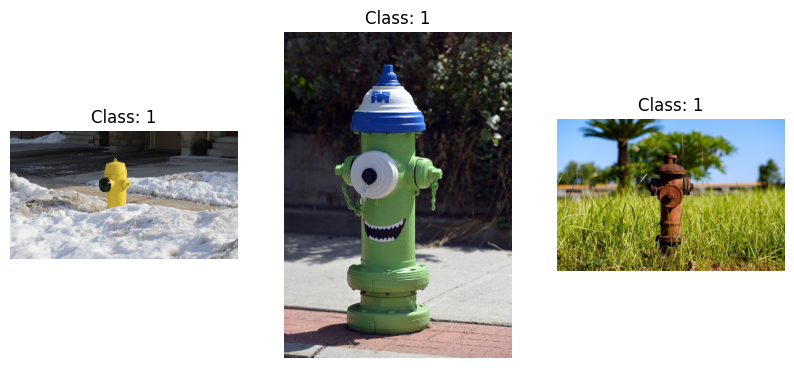

Samples without Fire Hydrant (Class 0):


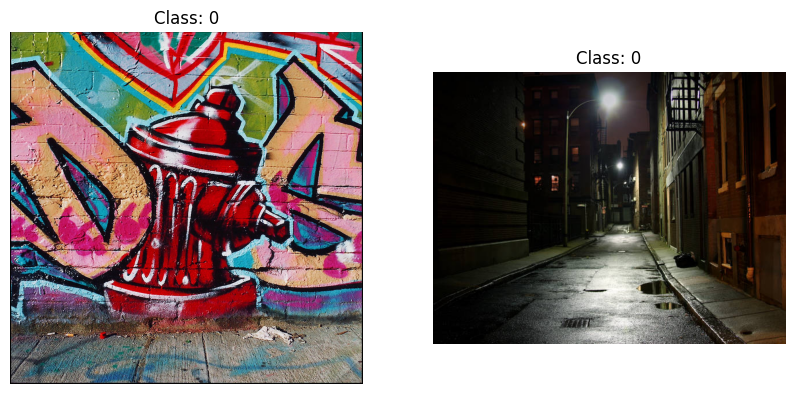

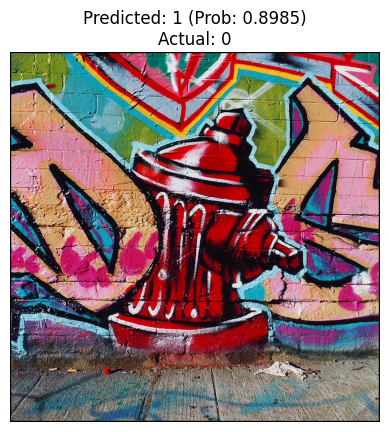

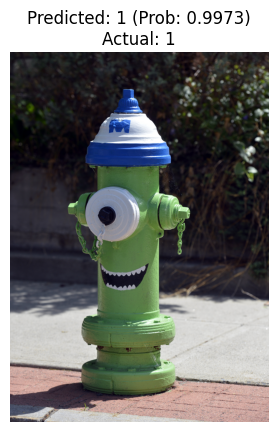

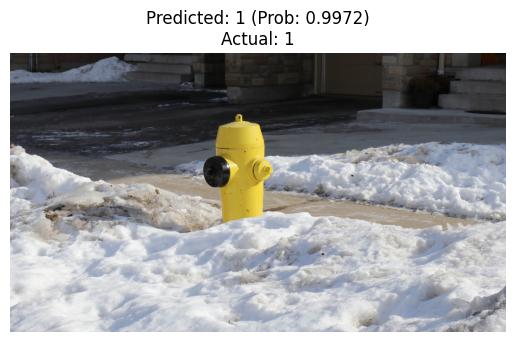

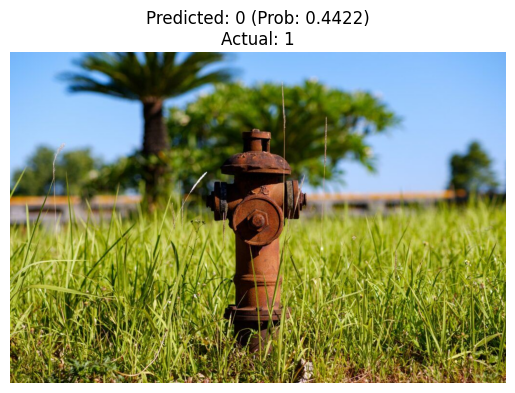

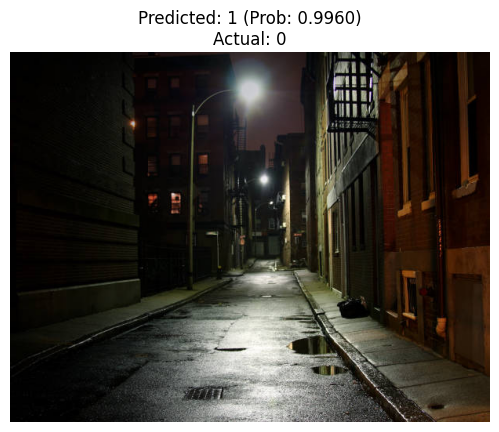

In [ ]:
# Test dataset path
test_data_path = "/content/drive/My Drive/Colab Notebooks/test/"
test_label = pd.read_csv('/content/drive/My Drive/Colab Notebooks/test/_classes.csv')

test_label['image_path'] = test_label['filename'].apply(lambda x: os.path.join(test_data_path, x))
# Display 3 samples from each class
print("Samples with Fire Hydrant (Class 1):")
display_images(test_label, class_label=1, num_samples=3)

print("Samples without Fire Hydrant (Class 0):")
display_images(test_label, class_label=0, num_samples=2)

test_label['resized_image'] = test_label['image_path'].apply(lambda x: np.array(resize_image(x)))

# Define transforms for test images
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to match the model's input size
    transforms.ToTensor(),  # Convert images to tensors
])

# Step 5: Make Predictions and Display Results
def predict_and_display(image_path, actual_label):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')  # Ensure image is in RGB format
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension and move to device

    # Make a prediction
    with torch.no_grad():
        output = dataAug_model(image_tensor)
        predicted_prob = output.item()
        predicted_label = 1 if predicted_prob > 0.5 else 0

    # Display the image, prediction, and actual label
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_label} (Prob: {predicted_prob:.4f})\nActual: {actual_label}")
    plt.axis('off')
    plt.show()

# Iterate over test images and display predictions
for index, row in test_label.iterrows():
    image_filename = row['image_path']  # Replace with the correct column name
    actual_label = row['Fire Hydrants']  # Replace with the correct column name
    image_path = os.path.join(test_data_path, image_filename)

    if os.path.exists(image_path):
        predict_and_display(image_path, actual_label)
    else:
        print(f"Image not found: {image_path}")

---

------

### 9) Final Thoughts
❓ How would you improve the model in the future?

✅ Your answer here..

In the future I would try combining multiple techniques at the same time, for instance make it hard on the model to learn through several varieties of options and allowing it more iterations to learn, but also stopping the learning early if it begins to perfore worse over time.

Also I think the data being populated with only city images, even though its in the right context, could be hurting the models ability to learn. I noticed when testing on a firehydrant in the middle of a field it could not detect the firehydrant and also when testing on a firehydrant painted on a wall it predicted with very high confidence that it existed.

-----